In [16]:
import os, sys, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io

from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle

%matplotlib inline

import scipy
import tensorflow as tf

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score


WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)

IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 42
TRAIN_NUM = 1000


In [17]:
path = '/media/amanpreet/Windows-SSD/Users/siaya/Downloads/'
path2 = '/home/amanpreet/Downloads/'
df_train = pd.read_csv(path+'trainLabels.csv')
df_test = pd.read_csv(path2+'test.csv')

print(df_train.shape)
print(df_test.shape)
print(df_train.head())

(35126, 2)
(1928, 1)
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


In [18]:
class_weights = df_train['level'].value_counts()
dfs = [df_train[df_train['level'] == i].sample(1200*(2 if i < 3 else 1),replace=True) for i in range(5)]
resampled = pd.concat(dfs, axis = 0).reset_index(drop=True)
resampled

,image,level
0,40740_right,0
1,27179_left,0
2,1422_right,0
3,9277_right,0
4,37301_left,0
...,...,...
9595,35112_right,4
9596,38064_right,4
9597,44247_left,4
9598,25378_right,4


In [19]:
resampled.level.value_counts()

0    2400
1    2400
2    2400
3    1200
4    1200
Name: level, dtype: int64

In [20]:
df_train=resampled

#### There are a number of ways to preprocess the images.

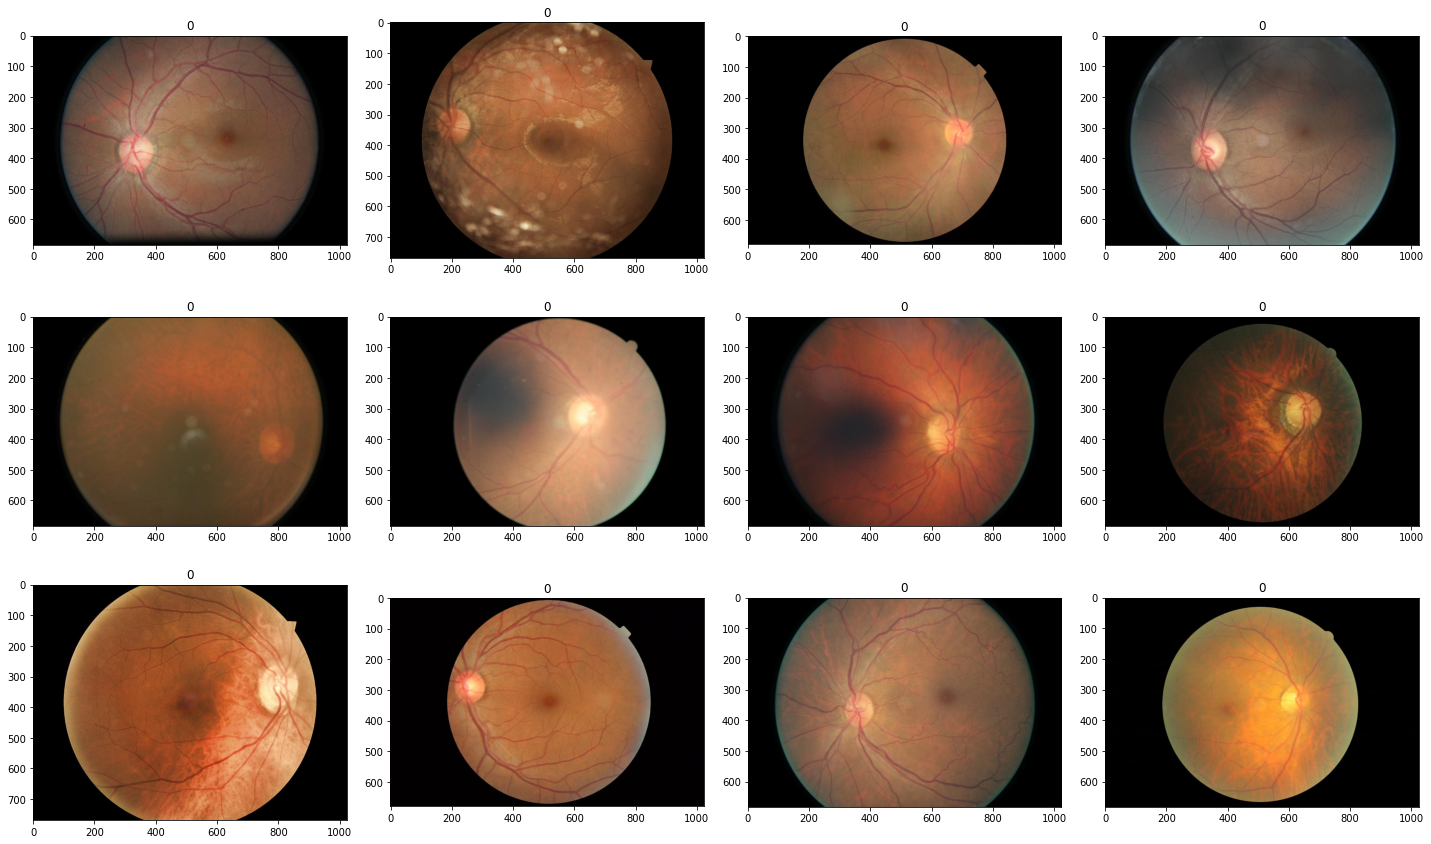

In [21]:
def display_samples(df, columns=4, rows=3, gauss=False):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level']
        img = cv2.imread(path+ f'resized_train/resized_train/{image_path}.jpeg')

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if gauss:
            img = cv2.addWeighted (img,4, cv2.GaussianBlur( img , (0,0) , IMG_SIZE/10) ,-4 ,128) 

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()
    
display_samples(df_train)

#### Using GuassianBlur

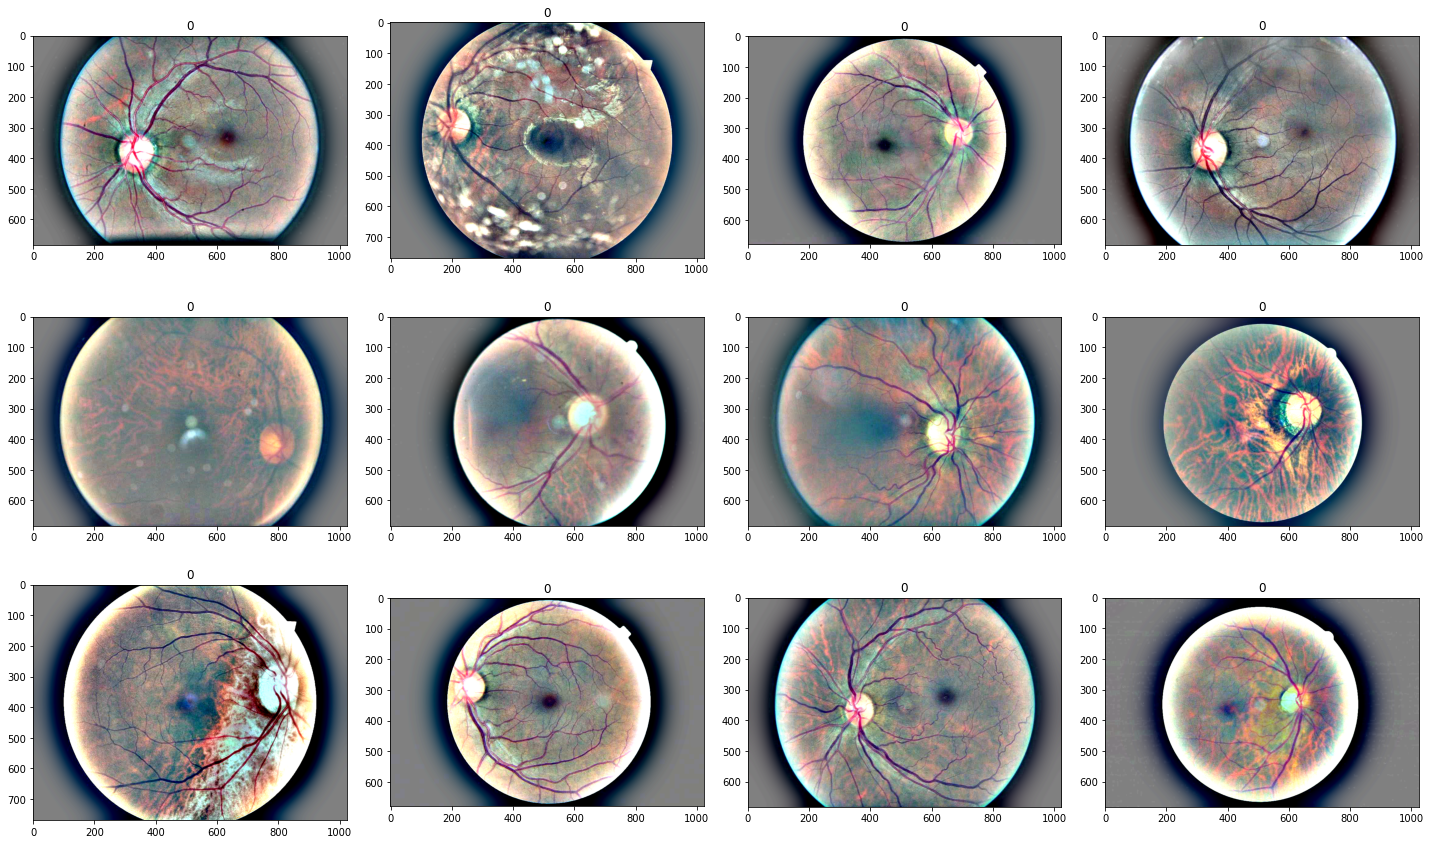

In [22]:
display_samples(df_train, gauss=True)

We will resize the images to 224x224, then create a single numpy array to hold the data.

In [23]:
def preprocess_image(image_path, desired_size=224, gauss=False):
    im = cv2.imread(image_path)
    im = cv2.resize(im, (desired_size, desired_size), interpolation = cv2.INTER_AREA)
    if gauss:
        im = cv2.addWeighted(im,4, cv2.GaussianBlur( im , (0,0) , desired_size/10) ,-4 ,128)
    
    return im

#### Resizing and applying blurr

In [24]:
N = df_train.shape[0]
x_train_array = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(df_train['image'])):
    x_train_array[i, :, :, :] = preprocess_image(path+
        f'resized_train/resized_train/{image_id}.jpeg',

        gauss=True
    )

100%|██████████| 9600/9600 [11:07<00:00, 14.37it/s]


Lets look at our new images!

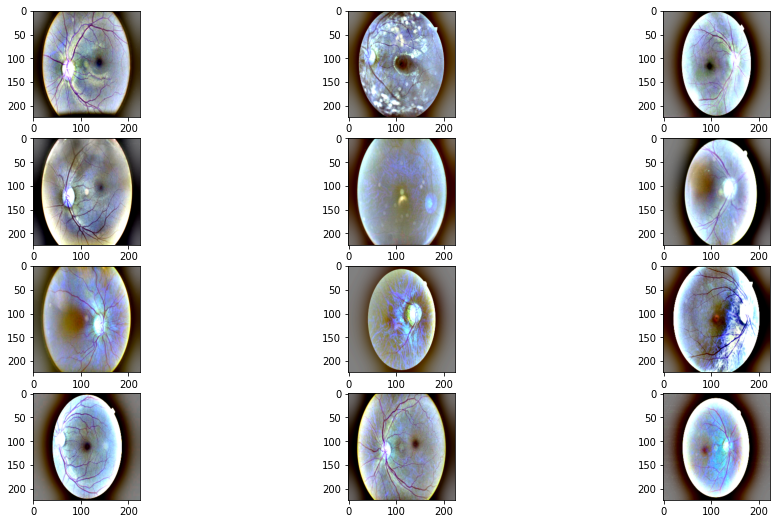

In [25]:
fig=plt.figure(figsize=(4*4, 3*3))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(x_train_array[i])

In [26]:
N = df_test.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(df_test['id_code'])):
    x_test[i, :, :, :] = preprocess_image(path2+
        f'test_images/{image_id}.png',
        gauss = True
    )

100%|██████████| 1928/1928 [03:06<00:00, 10.36it/s]


In [27]:
y_train = pd.get_dummies(df_train['level']).values

print(x_train_array.shape)
print(y_train.shape)
print(x_test.shape)

(9600, 224, 224, 3)
(9600, 5)
(1928, 224, 224, 3)


Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be [0, 0, 0, 1], but in our case we will predict [1, 1, 1, 1]. For more details, please check out Lex's kernel.

In [28]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [2400 2400 2400 1200 1200]
Multilabel version: [9600 7200 4800 2400 1200]


In [29]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_array, y_train_multi, 
    test_size=0.05, 
    random_state=2019
)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


(9120, 224, 224, 3) (9120, 5) (480, 224, 224, 3) (480, 5)


#### Building the data generator.

In [30]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
def build_CNN_model():
    model = Sequential()
    
    model.add(layers.Conv2D(128, 5, strides=2, activation="relu", input_shape=x_train[0].shape))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(32, 3, activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [20]:
model_cnn = build_CNN_model()
model_cnn.build()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 110, 110, 128)     9728      
_________________________________________________________________
batch_normalization_11 (Batc (None, 110, 110, 128)     512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 108, 108, 256)     295168    
_________________________________________________________________
batch_normalization_12 (Batc (None, 108, 108, 256)     1024      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 256)     590080    
_________________________________________________________________
batch_normalization_13 (Batc (None, 106, 106, 256)     1024      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 104, 104, 256)    

In [21]:
history = model_cnn.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/25
285/285 [==============================] - 145s 452ms/step - loss: 1.0665 - accuracy: 0.3227 - val_loss: 0.8883 - val_accuracy: 0.9479
Epoch 2/25
285/285 [==============================] - 130s 455ms/step - loss: 0.8588 - accuracy: 0.6789 - val_loss: 0.7627 - val_accuracy: 1.0000
Epoch 3/25
285/285 [==============================] - 129s 453ms/step - loss: 0.7371 - accuracy: 0.9022 - val_loss: 0.6671 - val_accuracy: 1.0000
Epoch 4/25
285/285 [==============================] - 129s 450ms/step - loss: 0.6528 - accuracy: 0.9708 - val_loss: 0.6201 - val_accuracy: 1.0000
Epoch 5/25
285/285 [==============================] - 128s 448ms/step - loss: 0.5897 - accuracy: 0.9928 - val_loss: 0.5783 - val_accuracy: 1.0000
Epoch 6/25
285/285 [==============================] - 129s 454ms/step - loss: 0.5370 - accuracy: 0.9946 - val_loss: 0.6009 - val_accuracy: 1.0000
Epoch 7/25
285/285 [==============================] - 130s 455ms/step - loss: 0.4930 - accuracy: 0.9931 - val_loss: 0.7059 -

<AxesSubplot:>

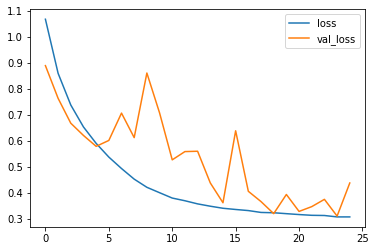

In [22]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

<AxesSubplot:>

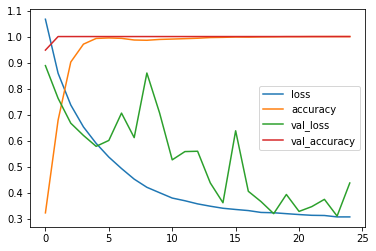

In [23]:
history_df.plot()

In [24]:
x_train_pred = model_cnn.predict(x_train) > 0.5
x_train_pred = x_train_pred.astype(int).sum(axis=1) - 1

x_val_pred = model_cnn.predict(x_val) > 0.5
x_val_pred = x_val_pred.astype(int).sum(axis=1) - 1

In [25]:
y_true_train = np.sum(y_train, axis=1) - 1
y_true_val = np.sum(y_val, axis=1) - 1

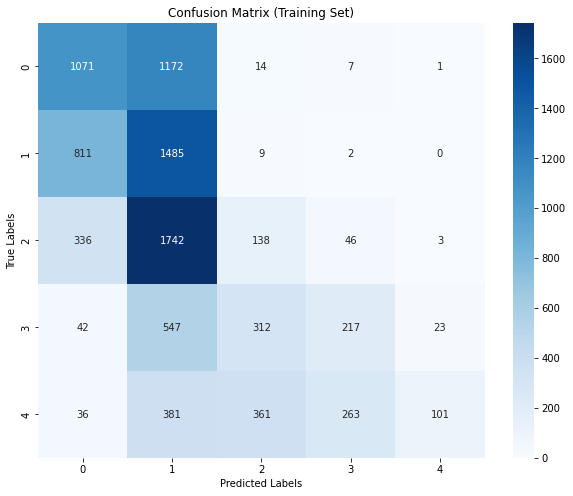

Recall (Training): 0.29121866448949374
Precision (Training): 0.42107391096147734
F1 Score (Training): 0.27314976595472906
Accuracy (Training): 0.33026315789473687


In [27]:
# Training Set
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm_train = confusion_matrix(y_true_train, x_train_pred)
recall_train = recall_score(y_true_train, x_train_pred, average='macro')
precision_train = precision_score(y_true_train, x_train_pred, average='macro')
f1_train = f1_score(y_true_train, x_train_pred, average='macro')
accuracy_train = accuracy_score(y_true_train, x_train_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()

print('Recall (Training):', recall_train)
print('Precision (Training):', precision_train)
print('F1 Score (Training):', f1_train)
print('Accuracy (Training):', accuracy_train)

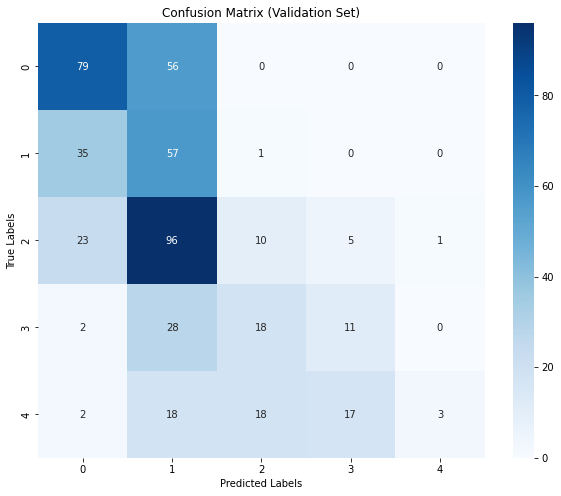

Recall (Validation): 0.3020654601925694
Precision (Validation): 0.415982478097622
F1 Score (Validation): 0.2691689426467199
Accuracy (Validation): 0.3333333333333333
Validation Set Shape: (480,)


In [28]:
cm_val = confusion_matrix(y_true_val, x_val_pred)
recall_val = recall_score(y_true_val, x_val_pred, average='macro')
precision_val = precision_score(y_true_val, x_val_pred, average='macro')
f1_val = f1_score(y_true_val, x_val_pred, average='macro')
accuracy_val = accuracy_score(y_true_val, x_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print('Recall (Validation):', recall_val)
print('Precision (Validation):', precision_val)
print('F1 Score (Validation):', f1_val)
print('Accuracy (Validation):', accuracy_val)
print('Validation Set Shape:', y_true_val.shape)

<b>BONUS PART: </b> TRANSFER LEARNING THROUGH DENSENET Model

In [34]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [32]:


def build_densenet_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
    )
    
    return model

In [35]:
model_densenet = build_densenet_model()
model_densenet.build()
model_densenet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [37]:
history = model_densenet.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=25,
    validation_data=(x_val, y_val)
)

Epoch 1/25
285/285 [==============================] - 126s 400ms/step - loss: 0.4640 - val_loss: 0.3781
Epoch 2/25
285/285 [==============================] - 113s 397ms/step - loss: 0.3378 - val_loss: 0.3227
Epoch 3/25
285/285 [==============================] - 113s 395ms/step - loss: 0.3126 - val_loss: 0.4779
Epoch 4/25
285/285 [==============================] - 113s 396ms/step - loss: 0.2899 - val_loss: 0.3039
Epoch 5/25
285/285 [==============================] - 115s 404ms/step - loss: 0.2769 - val_loss: 0.2719
Epoch 6/25
285/285 [==============================] - 113s 397ms/step - loss: 0.2672 - val_loss: 0.2778
Epoch 7/25
285/285 [==============================] - 114s 400ms/step - loss: 0.2565 - val_loss: 0.2604
Epoch 8/25
285/285 [==============================] - 114s 398ms/step - loss: 0.2474 - val_loss: 0.3214
Epoch 9/25
285/285 [==============================] - 113s 397ms/step - loss: 0.2392 - val_loss: 0.2772
Epoch 10/25
285/285 [==============================] - 115s 403m

<AxesSubplot:>

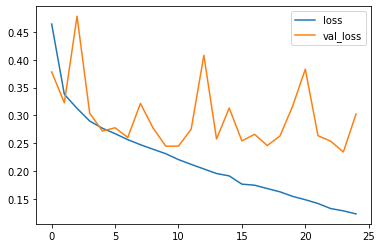

In [38]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [46]:
y_test = model_densenet.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

df_test['diagnosis'] = y_test
df_test.to_csv('submission.csv',index=False)

<AxesSubplot:>

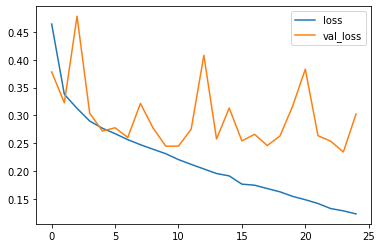

In [47]:
history_df.plot()

In [48]:
x_train_pred = model_densenet.predict(x_train) > 0.5
x_train_pred = x_train_pred.astype(int).sum(axis=1) - 1

x_val_pred = model_densenet.predict(x_val) > 0.5
x_val_pred = x_val_pred.astype(int).sum(axis=1) - 1

In [49]:
x_train_pred

array([2, 0, 1, ..., 0, 1, 3])

In [50]:
y_true_train = np.sum(y_train, axis=1) - 1
y_true_val = np.sum(y_val, axis=1) - 1

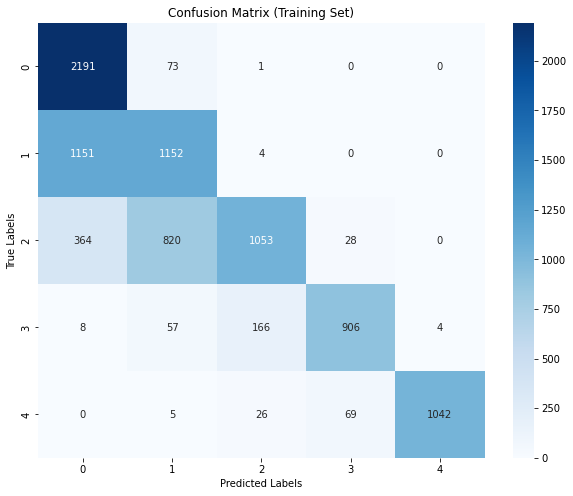

Recall (Training): 0.7276108053544901
Precision (Training): 0.7757089929157852
F1 Score (Training): 0.7303275572766441
Accuracy (Training): 0.6956140350877194


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

# Training Set
cm_train = confusion_matrix(y_true_train, x_train_pred)
recall_train = recall_score(y_true_train, x_train_pred, average='macro')
precision_train = precision_score(y_true_train, x_train_pred, average='macro')
f1_train = f1_score(y_true_train, x_train_pred, average='macro')
accuracy_train = accuracy_score(y_true_train, x_train_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()

print('Recall (Training):', recall_train)
print('Precision (Training):', precision_train)
print('F1 Score (Training):', f1_train)
print('Accuracy (Training):', accuracy_train)

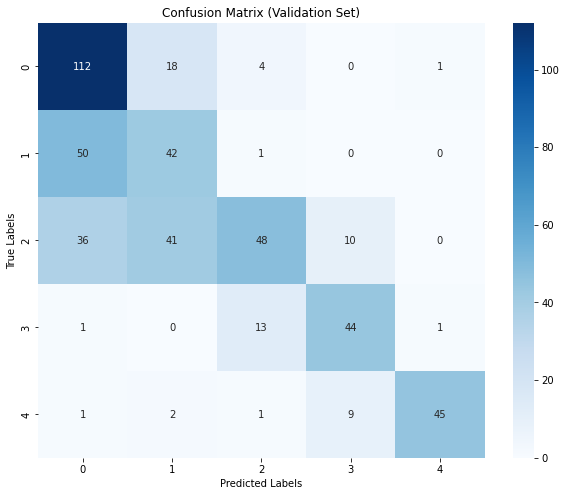

Recall (Validation): 0.6316845738481832
Precision (Validation): 0.6680088815324721
F1 Score (Validation): 0.6301860004589015
Accuracy (Validation): 0.60625
Validation Set Shape: (480,)


In [52]:
cm_val = confusion_matrix(y_true_val, x_val_pred)
recall_val = recall_score(y_true_val, x_val_pred, average='macro')
precision_val = precision_score(y_true_val, x_val_pred, average='macro')
f1_val = f1_score(y_true_val, x_val_pred, average='macro')
accuracy_val = accuracy_score(y_true_val, x_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print('Recall (Validation):', recall_val)
print('Precision (Validation):', precision_val)
print('F1 Score (Validation):', f1_val)
print('Accuracy (Validation):', accuracy_val)
print('Validation Set Shape:', y_true_val.shape)